<a href="https://colab.research.google.com/github/KW-plato/DriftDiffusionModel/blob/main/post_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Code to run after every experiment on the pair's data**

    Immediate feedback on the pair's accuracy, repetition bias, RT distribution and no. of sets of consecutive trials done by each
    Recodes the data
    saves the recoded data in a file named 'pairid.csv'. This file is later used by the HDDM and analysis codes



In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_palette("Set2", desat=0.5)

In [100]:
nLags = 10 #number of lag trials to be evaluated
datasrc = "drive/MyDrive/DDM_SP_2021-22/data"

In [152]:
# for experiments where files are split use this

"""
part1 = pd.read_csv("https://raw.githubusercontent.com/104H/dyadicdecisionmaking/2ifc-random-dots/data/DDM_pair725232_2021_Dec_07_1845.csv")
part2 = pd.read_csv("https://raw.githubusercontent.com/104H/dyadicdecisionmaking/2ifc-random-dots/data/DDM_pair725232_2021_Dec_07_1929.csv")
samples_df = pd.concat([part1,part2]).reset_index(drop=True)
"""


'\npart1 = pd.read_csv("https://raw.githubusercontent.com/104H/dyadicdecisionmaking/2ifc-random-dots/data/DDM_pair725232_2021_Dec_07_1845.csv")\npart2 = pd.read_csv("https://raw.githubusercontent.com/104H/dyadicdecisionmaking/2ifc-random-dots/data/DDM_pair725232_2021_Dec_07_1929.csv")\nsamples_df = pd.concat([part1,part2]).reset_index(drop=True)\n'

In [153]:
# for experiments where files are NOT split use this
samples_df = pd.read_csv("https://raw.githubusercontent.com/104H/dyadicdecisionmaking/2ifc-random-dots/data/DDM_pair958733_2021_Dec_03_0952.csv")

In [154]:
pair_id = samples_df['pair'][0]
samples_df.head()

,block,trial,s1_state,direction,response,rt,pair,Unnamed: 7
0,0,0,False,right,right,1.253093,958733,NaN
1,0,1,True,right,right,0.652851,958733,NaN
2,0,2,False,right,right,0.506876,958733,NaN
3,0,3,True,left,left,0.439048,958733,NaN
4,0,4,True,right,right,0.598979,958733,NaN


In [155]:
"""
Key params
"""
block_repeat = samples_df['block'].max() - 1
trials_per_block = samples_df['trial'].max() + 1

In [156]:
"""
Helper Functions
"""
def keep_neccessary_columns(df):
    '''
    Keep only columns that contain important data.
    This targets getting rid mainly columns named ".this...".
    '''
    return(df[['pair','block','trial','s1_state','direction','response','rt']])

def determine_correct_responses(df):
    '''
    If the response and direction of dots match then correct else not
    '''
    condition = df['direction'] == df['response'] 
    df['correct'] = 0
    df.loc[condition, 'correct'] = 1
    
    return df

def segregate_trial_data(df):
    """
    Segregate and arrange data on a per subject basis since analysis is done per subject.
    Output: every row is a trial data for the 'DO' subject. the dyad is by default in 'OBSERVE' state
    every subject is given a subject id : pair-id_1 or pair-id_2
    """
    temp = df.copy()
    temp['subj_idx'] = temp['pair'].apply(str) 
    #'subj_idx' literal needed for HDDM see https://groups.google.com/g/hddm-users/c/Dhohjq_U2kU
    temp.loc[temp['s1_state']==1,'subj_idx'] = temp.loc[temp['s1_state']==1,'subj_idx'] + '_1'
    temp.loc[temp['s1_state']==0,'subj_idx'] = temp.loc[temp['s1_state']==0,'subj_idx'] + '_2'
    
    return temp

"""
def determine_response_type(df):

    #Is the current response repeat or alternate of the immediate past response

    df['repeat'] = df['response'] == df['response'].shift(periods=1)
    df['repeat'] = df['repeat'].map({True:'repeat',False:'alternate'})
    
    return df
"""
    
def collect_previous_trials(df,nprev=1):
    
    """
    Collate data of the n-th previous trial
    """
    
    prefix = 'prev' if nprev == 1 else 'prev' + str(nprev) #prefix for the column name
    
    """
    What was the stimulus of the n-th previous trial?  
    """
    col_name = prefix + 'stim'
    df[col_name] = df['direction'].shift(periods=nprev)
    
    """
    What was the response of the n-th previous trial? ?  
    """
    col_name = prefix + 'resp'
    df[col_name] = df['response'].shift(periods=nprev)
    
    """
    Who did the n-th previous trial?
    """
    col_name = prefix + 'subject'
    df[col_name] = df['subj_idx'].shift(periods=nprev)
    
    """
    Was the n-th previous trial response correct or incorrect?
    """
    col_name = prefix + 'correct'
    condition = df[prefix + 'stim'] == df[prefix + 'resp'] 
    df[col_name] = 0
    df.loc[condition, col_name] = 1
    
    """
    Is the current response repeat of the n-th previous response
    """
    col_name = prefix + 'repeat'
    df[col_name] = df['response'] == df['response'].shift(periods=nprev)
    df[col_name] = df[col_name].map({True:1,False:0})
    
    return df

"""
Remove trials where RTs are outliers. ref Urai paper.
"""
def remove_outliers(df):

    df['rt'] = df['rt'].astype(float)
    RTstd = 4
    outlier_dict = {}
    subs = df.subj_idx.unique()

    for subject in subs:
        # create subset of dataframe
        subset = df.loc[samples_df.subj_idx==subject]

        values = subset.loc[:,'rt'].values
        mean = np.mean(values)
        std = np.std(values)
        thresh = mean + (std*RTstd)

        # get indices of outliers
        idx = subset.loc[(subset.rt) > thresh].index

        # add amount of outliers to dictionary
        if len(idx)==0:
            outlier_dict[subject] = 0
        else:
            outlier_dict[subject] = len(idx)
            df = df.drop(idx).reset_index(drop=True)

    return df, outlier_dict

"""
Calculate the features of nth lag trial.
n=1 is the immediately previous trial.
"""
def get_lag_trial(df,nprev=1): #no need to return the dataframe since it gets modified in place
    tmp_list = []
    prefix = 'l' + str(nprev) + '_' #prefix for the column name
    #there is a gap in experiment between every block, so all lag features are calculated within a block only
    for block in df['block'].unique():
        block_select = df['block'] == block
        df.loc[block_select,prefix + 'stim'] = df.loc[block_select,'direction'].shift(periods=nprev)
        df.loc[block_select,prefix + 'resp'] = df.loc[block_select,'response'].shift(periods=nprev)
        df.loc[block_select,prefix + 'subject'] = df.loc[block_select,'subj_idx'].shift(periods=nprev)
        #is current response repeat of the nth prev response
        df.loc[block_select,prefix + 'repeat'] = (df.loc[block_select,'response'] == df.loc[block_select,'response'].shift(periods=nprev)) * 1 # converts to 1 or 0
    
    for s in subjects:
        tmp_dict = {}
        tmp_dict['lag'] = nprev
        tmpdf = df[(df['subj_idx']==s) & (~df[prefix + 'stim'].isna())] #remove the trials which are NaN
        owntrials = tmpdf[prefix + 'subject'] == s
        tmp_dict['subj_idx'] = s
        tmp_dict['pr'] = tmpdf[prefix + 'repeat'].mean()
        tmp_dict['pr_own'] = tmpdf.loc[owntrials, prefix + 'repeat'].mean()
        tmp_dict['pr_other'] = tmpdf.loc[~owntrials, prefix + 'repeat'].mean()
        tmp_list.append(tmp_dict)
         
    return tmp_list
    

In [157]:
samples_df = determine_correct_responses(
                segregate_trial_data(
                        keep_neccessary_columns(samples_df)))

samples_df.drop(['pair','s1_state'],axis=1,inplace=True)
subjects = samples_df['subj_idx'].unique()

In [158]:
samples_df.head()

,block,trial,direction,response,rt,subj_idx,correct
0,0,0,right,right,1.253093,958733_2,1
1,0,1,right,right,0.652851,958733_1,1
2,0,2,right,right,0.506876,958733_2,1
3,0,3,left,left,0.439048,958733_1,1
4,0,4,right,right,0.598979,958733_1,1


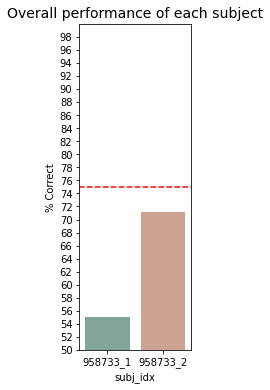

In [159]:
fig, ax = plt.subplots(figsize=(2,6))
tmpdf = (samples_df
         .groupby(['subj_idx'])['correct']
         .value_counts(normalize=True)
         .unstack(fill_value=0)
         .stack()
         .rename("proportion")
         .reset_index()
        )
tmpdf["proportion"] = tmpdf["proportion"] * 100
sns.barplot(x="subj_idx", y="proportion", data=tmpdf[tmpdf["correct"]==1],ax=ax)
ax.axhline(75,color='red',linestyle='--')
ax.set_title("Overall performance of each subject", fontsize=14)
ax.set_ylim((50,100))
ax.set_yticks(np.arange(50,100,2))
ax.set_ylabel("% Correct")
plt.show()


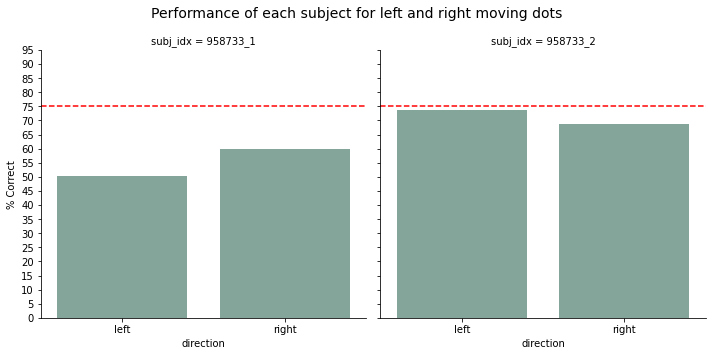

In [160]:
tmpdf = (samples_df
         .groupby(['subj_idx','direction'])['correct']
         .value_counts(normalize=True)
         .unstack(fill_value=0)
         .stack()
         .rename("proportion")
         .reset_index()
        )
tmpdf["proportion"] = tmpdf["proportion"] * 100
g = sns.catplot(
    data=tmpdf[tmpdf["correct"]==1],
    x='direction',
    y='proportion', 
    hue='correct', 
    col='subj_idx', 
    kind='bar',
    legend=False
)
g.fig.subplots_adjust(top=0.86)
g.fig.suptitle('Performance of each subject for left and right moving dots', fontsize=14)
g.set(ylabel="% Correct")
g.axes[0][0].set_yticks(np.arange(0,100,5))
g.axes[0][1].set_yticks(np.arange(0,100,5))
g.axes[0][0].axhline(y=75, color='red', linestyle='--')
g.axes[0][1].axhline(y=75, color='red', linestyle='--')
plt.show()

In [161]:
individual = []
for nprev in range(1,nLags+1):
    individual.extend(get_lag_trial(samples_df,nprev))
    
individual_df = pd.DataFrame(individual)


In [162]:
display(individual_df) 

,lag,subj_idx,pr,pr_own,pr_other
0,1,958733_2,0.463462,0.453237,0.475207
1,1,958733_1,0.482979,0.508850,0.459016
2,2,958733_2,0.530097,0.580292,0.473029
3,2,958733_1,0.492473,0.497738,0.487705
4,3,958733_2,0.530452,0.568773,0.487500
5,3,958733_1,0.488069,0.465438,0.508197
6,4,958733_2,0.586957,0.594203,0.578261
7,4,958733_1,0.464758,0.465753,0.463830
8,5,958733_2,0.533730,0.578358,0.483051
9,5,958733_1,0.526906,0.586538,0.474790


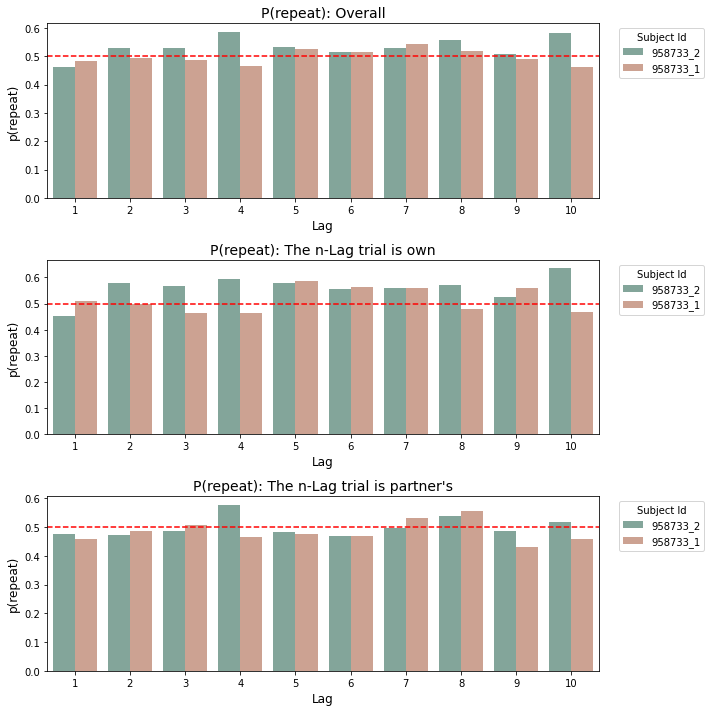

In [163]:
fig, ax = plt.subplots(3,1,figsize=(10,10))
g1 = sns.barplot(
    data=individual_df,
    x='lag',
    y= 'pr',
    hue='subj_idx',
    ax=ax[0])

g2 = sns.barplot(
    data=individual_df,
    x='lag',
    y= 'pr_own',
    hue='subj_idx',
    ax=ax[1])

g3 = sns.barplot(
    data=individual_df,
    x='lag',
    y= 'pr_other',
    hue='subj_idx',
    ax=ax[2])

ax[0].set_title("P(repeat): Overall",fontsize=14)
ax[1].set_title("P(repeat): The n-Lag trial is own",fontsize=14)
ax[2].set_title("P(repeat): The n-Lag trial is partner's",fontsize=14)

for i in range(3):
    ax[i].axhline(y=0.5, color='red', linestyle='--')
    ax[i].set_xlabel("Lag",fontsize=12)
    ax[i].set_ylabel("p(repeat)",fontsize=12)
    ax[i].legend(loc='upper right',bbox_to_anchor=(1.2, 1),title="Subject Id" )

plt.tight_layout()
plt.show()

In [164]:
#remove RT outliers
"""
Should we remove outliers first and then do the rest of the analysis?
Problem: in-between some trials get lost so the previous trials are not really previous trials
If we remove outliers later?
The removed trials continue to impact since they persist in the previous trial calculations
"""
samples_df, outlier = remove_outliers(samples_df)
print('No. of outliers: ' + str(outlier))

No. of outliers: {'958733_2': 3, '958733_1': 2}


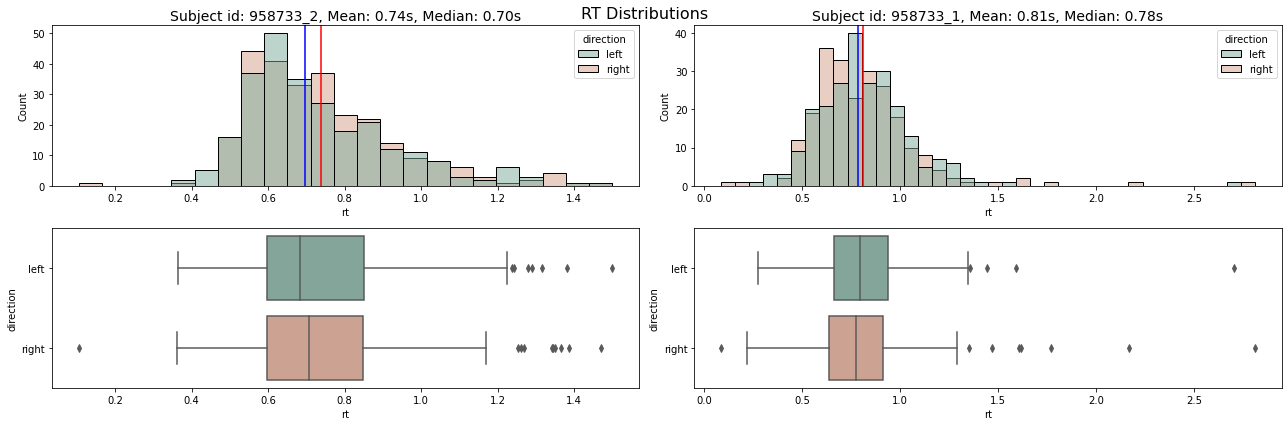

In [165]:
#plot RT distributions for left and right for each  subject
fig, ax = plt.subplots(2,2,figsize=(18,6))
fig.suptitle("RT Distributions",fontsize=16)
for i,s in enumerate(subjects):
    df = samples_df.loc[samples_df['subj_idx']==s]
    me = df['rt'].mean()
    med = df['rt'].median()
    #df.loc[df['direction']== 'left','rt'] *= -1
    #n, bins, patches = ax[0][i].hist(df['rt'], 50, density=True, facecolor='g', alpha=0.75)
    sns.histplot(data=df,x='rt', hue='direction',stat='count',ax=ax[0][i],hue_order=['left','right'])
    ax[0][i].axvline(me,color='red')
    ax[0][i].axvline(med,color='blue')
    ax[0][i].set_title("Subject id: {}, Mean: {:3.2f}s, Median: {:3.2f}s".format(s,me,med),fontsize=14)
    sns.boxplot(data=df,x='rt',y='direction',order=['left','right'],ax=ax[1][i])

plt.tight_layout()
plt.show()


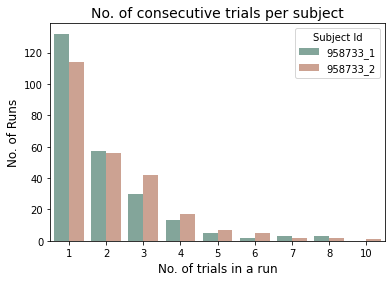

In [166]:
"""
How many runs of n-consecutive trials did each subject did?

Call a set of consecutive trials by the same subject a 'run'.
A run can be from 1 trial to any number since it is randomly selected which subject will be "DO".
Sumamrize how many differnt kinds of run did each subject get
"""
#assign a run_id to each trial identifying all trials that belong to the same run
samples_df['run_id']=(samples_df['subj_idx'] != samples_df['subj_idx'].shift()).cumsum()
#summarize per subject: how many trials are in each run_id
conseq = samples_df.groupby(['subj_idx'])['run_id'].value_counts().rename('conseq').reset_index()
#summarize per subject: how many runs of differnt sizes 
trials_df = conseq.groupby(['subj_idx'])['conseq'].value_counts().rename('nTrials').reset_index()
#plot 
fig, ax = plt.subplots()
sns.barplot(
    data=trials_df,
    x='conseq',
    y= 'nTrials',
    hue='subj_idx',
    ax=ax)
ax.legend(loc='upper right',title="Subject Id")
ax.set_ylabel("No. of Runs",fontsize=12)
ax.set_xlabel("No. of trials in a run",fontsize=12)
plt.title("No. of consecutive trials per subject",fontsize=14)
plt.show()


In [167]:
"""
Recode data 
Codes:
for stimulus and response left,right :: -1,1
for correctness, correct,incorrect:: 1,0 already done during calculations
"""
samples_df.replace({'left':-1,'right':1},inplace=True)

In [168]:
#save the file
#samples_df.drop(columns=['run_id'],axis=1,inplace=True)
samples_df.to_csv(os.path.join(datasrc,'coded','pair' + str(pair_id) + '.csv' ),header=True,index=False)